# 使用Keras來破解captcha驗證碼

當人們在網站註冊或購物時，經常會出現圖像驗證碼的輸入要求，為了區分「真人」，圖片會出現線條及扭曲分隔開的文字，讓 爬蟲/惡意程式難以辨識，但這種方式因為深度學習的視覺辨識能力的增強而容易被破解。

本文會通過Keras搭建一個深度卷積神經網絡來識別一個固定長度captcha驗證碼。

**captcha**是用python寫的生成驗證碼的函式庫，它支持動態產生圖片驗證碼和語音驗證碼，我們使用的是它生成圖片驗證碼的功能來產生模型的訓練資料與驗證資料。並透過Keras的generator功能來直接使用captcha所產生的圖像, 而不需要預先把資料產生在檔案中。

![captcha](https://geekreply.com/wp-content/uploads/2017/10/captcha-136419892493002601.jpg)

## Captcha驗證碼
首先我們設置我們的驗證碼格式為數字加大寫字母，生成一串驗證碼試試看：

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


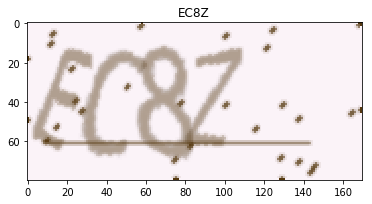

In [1]:
# 載入產生Capthca的函式庫
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

import string

characters = string.digits + string.ascii_uppercase
print(characters) # 打印一下會用到的字母

# Captcha生成圖像的寬高、用幾個字母來組成字串及會用到的字母數
width, height, n_len, n_class = 170, 80, 4, len(characters)

generator = ImageCaptcha(width=width, height=height) # 設定captcha圖像的長寬

# 產生4個字母的captcha
random_str = ''.join([random.choice(characters) for j in range(4)]) 
img = generator.generate_image(random_str)

# 把Captcha秀出來
plt.imshow(img)
plt.title(random_str)
plt.show()

## 數據生成器

訓練模型的時候，我們可以選擇兩種方式來生成我們的訓練數據，一種是一次性生成幾萬張圖，
然後開始訓練，一種是定義一個數據生成器，然後利用fit_generator函數來訓練。

第一種方式的好處是訓練的時候顯卡利用率高，如果你需要經常調參，可以一次生成，多次使用;
第二種方式的好處是你不需要生成大量數據，訓練過程中可以利用CPU生成數據，而且還有一個好處
是你可以無限生成數據。

我們的數據格式如下：

### X

X的形狀是（batch_size，height，width，3），比如生成一個有32個彩色樣本的批次，圖片高度為80，寬度為170，那麼張量形狀就是（32，80，170，3），取第一張圖就是X[0]。

### y

y的張量形狀是四個（batch_size，n_class），如果轉換成numpy的格式，則是（n_len，batch_size，n_class），比如一批生成32個樣本，驗證碼的字符有36種，長度是4位， 那麼它的形狀就是4個（32，36），也可以說是（4，32，36）。

ps.請特別注意**y**的資料結構(4, 32, 36)是會對應到網絡4個softmax的輸出

In [2]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

上面就是一個可以無限生成圖像數據的例子，我們將使用這個生成器來產生圖像資料來訓練我們的模型。

## 使用生成器

生成器的使用方法很簡單，只需要使用next()函數即可。下面是一個範例，生成32個圖像數據，然後顯示第一個圖像數據。當然，在這裡我們還對生成的One-Hot編碼後的數據進行解碼，首先將它轉為numpy數組，然後取36個字符中最大的數字的位置，因為神經網絡會輸出36個字符的機率，然後將機率最大的四個字符的編號轉換為字串。

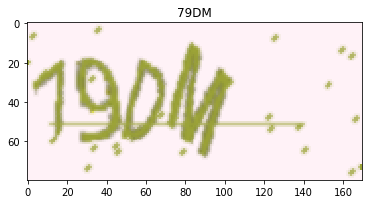

In [3]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1)) # 產生一個批次數量為1的數據

plt.imshow(X[0])
plt.title(decode(y))
plt.show()

## 構建深度卷積神經網絡

模型結構很簡單，特徵提取部分使用的是兩個卷積，一個池化的結構，這個結構是學VGG16的結構。之後我們將它展開，然後添加Dropout，
盡量避免過擬合(overfitting)問題，最後連接四個分類器，每個分類器是36個神經元，輸出36個字符的機率。
這個網絡模型比較特別的地方就在最後的四個分類器的設計, 有關"多輸出模型"的說明可以參考:[如何使用Keras函數式API進行深度學習](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.1-keras-functional-api.ipynb) - [5.2 多輸出模型]。

In [4]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor

# 產生有四個 block的卷積網絡
for i in range(4):
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
x = Flatten()(x)
x = Dropout(0.25)(x)

# 多輸出模型, 由次這個captcha是有4個字母(固定長度), 因此我們對應使用了4個'softmax'來分別預測4個字母的產出
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 76, 166, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## 模型可視化

得益於Keras自帶的可視化工具，我們可以使用幾行程式碼來可視化模型的結構：

Ps.這裡需要使用pydot以及graphviz這兩個函式庫。使用Windows作業系統的人可以參考-[[Setting_up_pydot_for_Python_3_5_Keras_Conda_Windows_64](http://justinwatson.name/2017/02/10/Setting_up_pydot_for_Python_3_5_Keras_Conda_Windows_64.html)]來進行設定安裝

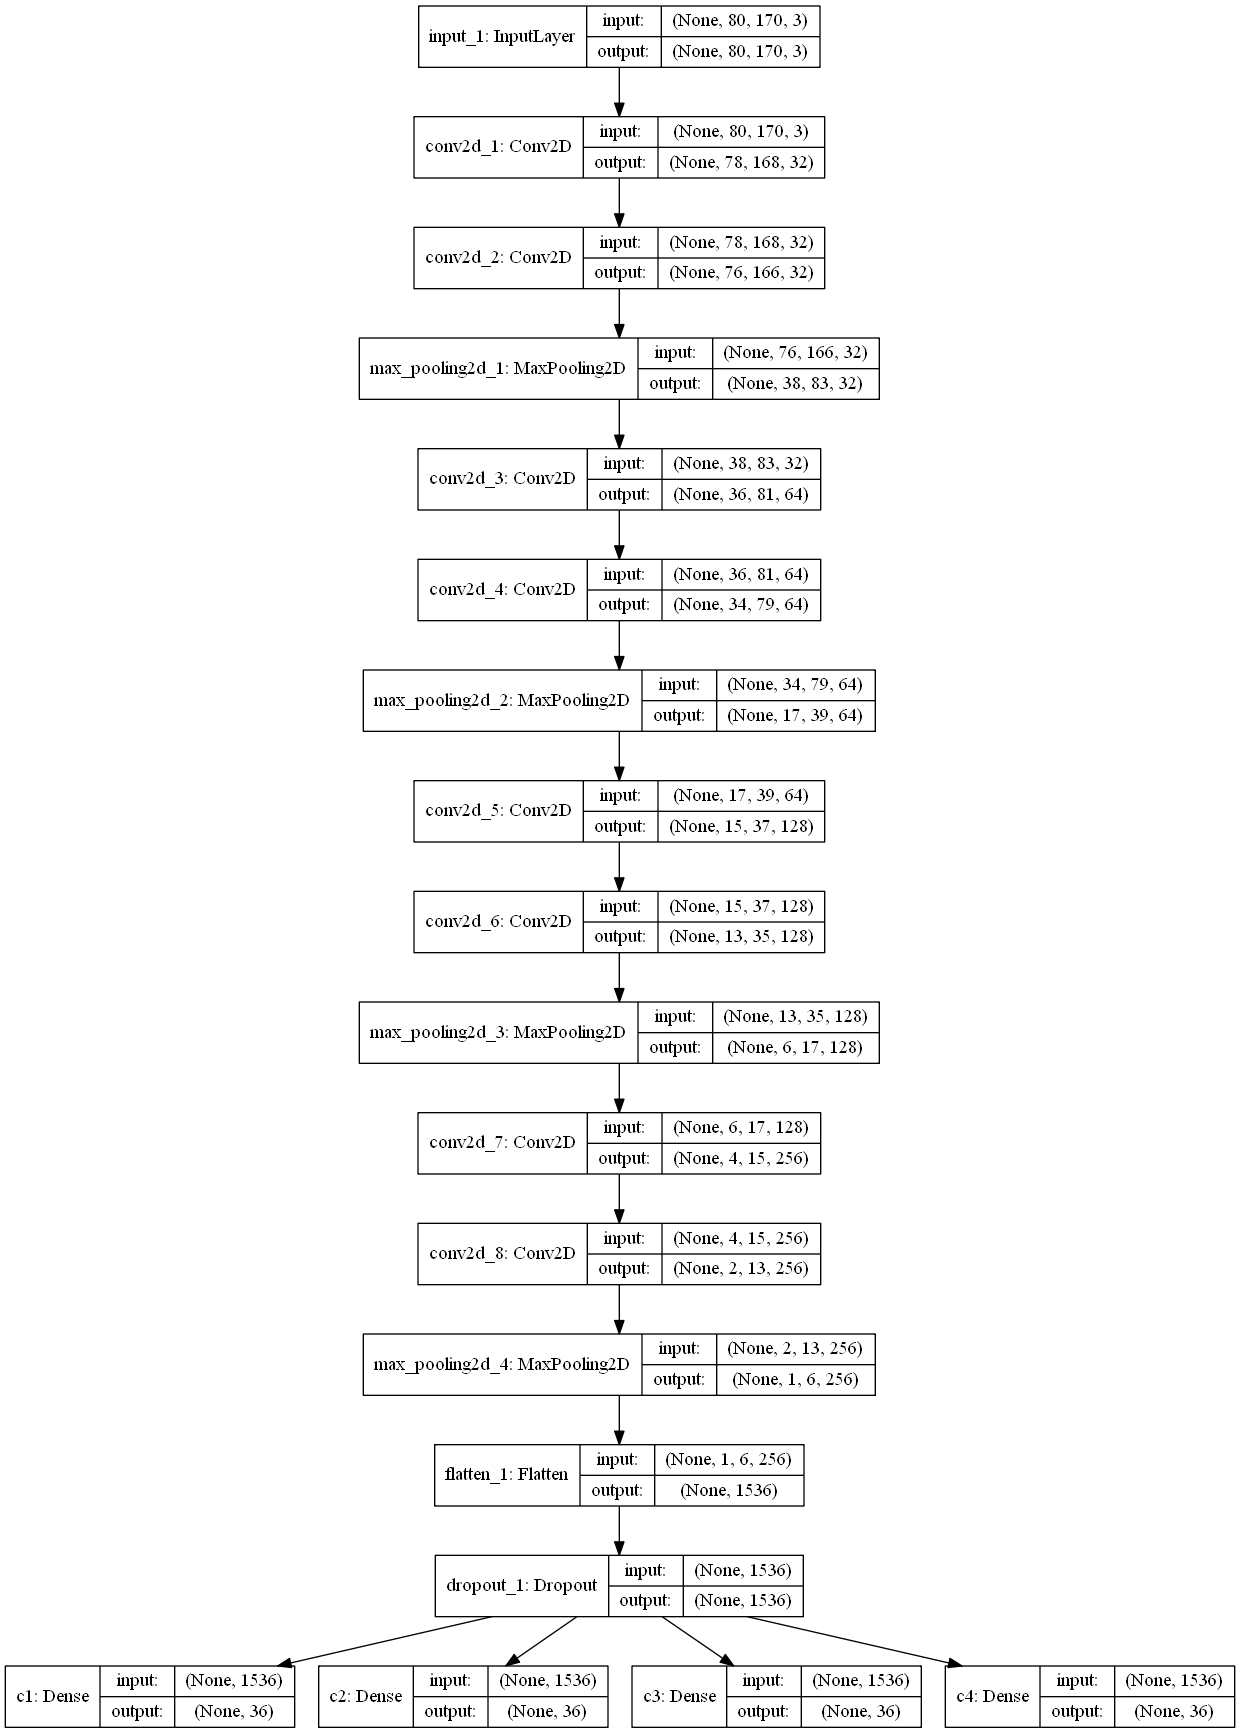

In [5]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

我們可以看到最後一層卷積層輸出的張量形狀是（1，6，256），已經不能再加卷積層了。

## 訓練模型



訓練模型反而是所有步驟裡面最簡單的一個，直接使用model.fit_generator即可，這裡的驗證集使用了同樣的生成器，
由於數據是通過生成器隨機生成的，所以我們不用考慮數據是否會重複。

注意，這段程式碼可能要耗費一下的時間。如果你想讓模型預測得更準確，可以將nb_epoch改為10或者20，但它也會耗費成倍的時間。

In [6]:
from keras import callbacks
cbks = [callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)]

history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                    steps_per_epoch=1600,    # 每次的epoch要訓練1600批量的資料
                    epochs=5,                # 總共跑5個訓練循環
                    callbacks=cbks,          # 保存最好的模型到檔案
                    validation_data=gen(),   # 驗證資料也是用生成器來產生
                    validation_steps=40      # 用40組資料來驗證
                   ) 

Epoch 1/5
1600/1600 [==============================] - 99s 62ms/step - loss: 14.3638 - c1_loss: 3.5906 - c2_loss: 3.5903 - c3_loss: 3.5907 - c4_loss: 3.5923 - c1_acc: 0.0285 - c2_acc: 0.0283 - c3_acc: 0.0292 - c4_acc: 0.0286 - val_loss: 14.3333 - val_c1_loss: 3.5834 - val_c2_loss: 3.5824 - val_c3_loss: 3.5834 - val_c4_loss: 3.5841 - val_c1_acc: 0.0250 - val_c2_acc: 0.0305 - val_c3_acc: 0.0312 - val_c4_acc: 0.0352
Epoch 2/5
1600/1600 [==============================] - 97s 60ms/step - loss: 6.3264 - c1_loss: 1.9295 - c2_loss: 1.3399 - c3_loss: 1.4713 - c4_loss: 1.5857 - c1_acc: 0.4729 - c2_acc: 0.5997 - c3_acc: 0.5716 - c4_acc: 0.5768 - val_loss: 1.3688 - val_c1_loss: 0.4813 - val_c2_loss: 0.1518 - val_c3_loss: 0.2378 - val_c4_loss: 0.4979 - val_c1_acc: 0.9117 - val_c2_acc: 0.9594 - val_c3_acc: 0.9313 - val_c4_acc: 0.9125
Epoch 3/5
1600/1600 [==============================] - 97s 61ms/step - loss: 1.3388 - c1_loss: 0.5041 - c2_loss: 0.1258 - c3_loss: 0.2028 - c4_loss: 0.5060 - c1_acc: 0.

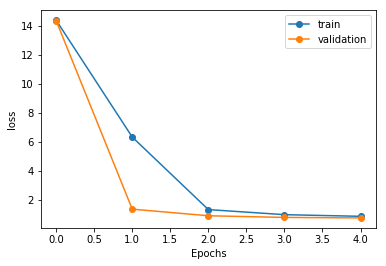

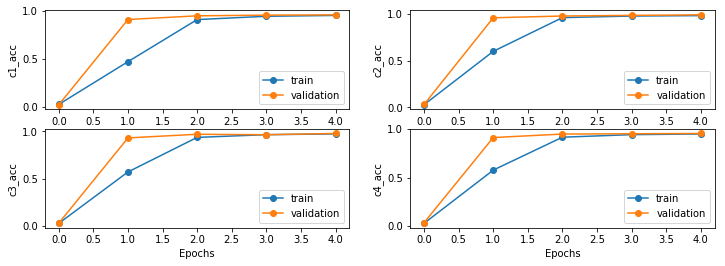

In [7]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

# 打印整體的loss與val_loss
plot_train_history(history, 'loss', 'val_loss')
    
plt.figure(figsize=(12,4))

# 第一個字母的正確率
plt.subplot(2,2,1)
plot_train_history(history, 'c1_acc','val_c1_acc')

# 第二個字母的正確率
plt.subplot(2,2,2)
plot_train_history(history, 'c2_acc','val_c2_acc')

# 第三個字母的正確率
plt.subplot(2,2,3)
plot_train_history(history, 'c3_acc','val_c3_acc')

# 第四個字母的正確率
plt.subplot(2,2,4)
plot_train_history(history, 'c4_acc','val_c4_acc')

plt.show()

## 測試模型

當我們訓練完成以後，可以識別一個驗證碼試試看：

In [8]:
from keras.models import load_model

del model  # 移除現在在記憶體的模型
model = load_model('best_model.h5') # 載入在訓練過程儲存下來的模型

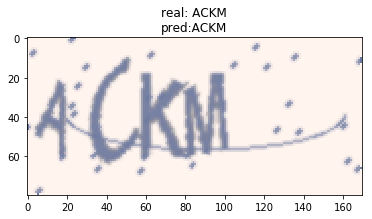

In [9]:
X, y = next(gen(1)) # 產生一筆新的測試資料
y_pred = model.predict(X) # 進行預測

# 展示結果
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.show()

## 計算模型總體準確率

模型在訓練的時候只會顯示每一個字符的準確率，為了統計模型的總體準確率，我們可以寫下面的函數：

In [10]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0 # 對的筆數
    batch_count = 0 # 總筆數
    
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator) # 產生一批次的圖像資料與答案
        y_pred = model.predict(X) # 進行預測
        y_pred = np.argmax(y_pred, axis=2).T # 轉置矩陣 (4, 32) -> (32, 4)
        y_true = np.argmax(y, axis=2).T # 轉置矩陣 (4, 32) -> (32, 4)
        
        # 比對兩個矩陣是每個cell(character)都是相同的, 全部相同才算答對
        for i in range(len(y_pred)):
            batch_count += 1
            if np.array_equal(y_true[i], y_pred[i]):
                batch_acc += 1
    # 計算正確率
    return batch_acc / batch_count

# 讓我們測試一下模型的總體準確率
evaluate(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.06it/s]


0.9390625

這裡用到了一個函式庫叫做tqdm，它是一個展示進度條的函式庫，為的是能夠實時反饋程式執行的進度。

我們透過一些numpy計算去統計我們的預測準確率，這裡計算規則是四個產生值裡只要有一個錯，那麼就不算它對。經過計算，我們的模型的總體準確率在經過5次的循環後就可以達到91%左右，繼續訓練還可以達到更高的準確率。

## 模型總結

模型的大小是16MB，在我的筆記本上跑1000張驗證碼需要用20秒，當然，顯卡會更快。對於驗證碼識別的問題來說，哪怕是10％的準確率也已經稱得上破解，畢竟假設100％識別率破解要一個小時，那麼10％的識別率也只用十個小時，還算等得起，而我們的識別率有91％，已經可以稱得上破解了這類驗證碼的安全性了。

## 改進

以上模型對於固定長度的captcha己經可以有了很不錯的辨識結果, 但是對於不定長度的captcha就無法應付了。如果要繼續改進不定長度的對captcha，我們可以使用遞歸神經網絡(RNN)來識別文字序列。

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:
    
* 一個由卷積網絡所淬取出的features map如何被多個output所使用
* 需要了解網絡的結構與不同網絡層輸入輸出的張量的結構才能夠清楚地構建一個對的模型
* 深度學習在圖像的應用真的需要想像力、創造力與實作力

參考: 
* [使用 Keras 来破解 captcha 验证码](https://ypw.io/captcha/)
* [Keras範例-image_orc.py](https://github.com/fchollet/keras/blob/master/examples/image_ocr.py)
* [Keras官網](http://keras.io/)